In [1]:
# import libraries
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 128
# validation set precentage 
valid_size = 0.2 #20% from training set

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.FashionMNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False,
                                  download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)
print("train set length      : {:d}".format(train_sampler.indices.__len__()))
print("validation set length : {:d}".format(valid_sampler.indices.__len__()))
print("test set length       : {:d}".format(test_loader.dataset.__len__()))

train set length      : 48000
validation set length : 12000
test set length       : 10000


In [4]:
labelsDic = {
    0 : "T-shirt/top",
    1 : "Trouser",
    2 : "Pullover",
    3 : "Dress",
    4 : "Coat",
    5 : "Sandal",
    6 : "Shirt",
    7 : "Sneaker",
    8 : "Bag",
    9 : "Ankle Boot"
}

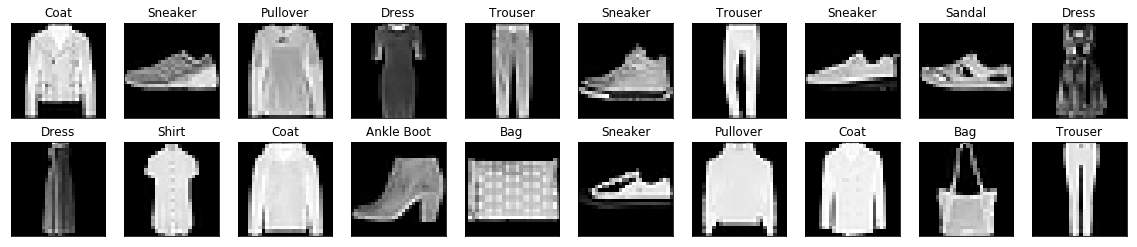

In [5]:
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    ax.set_title(str(labelsDic[labels[idx].item()]))

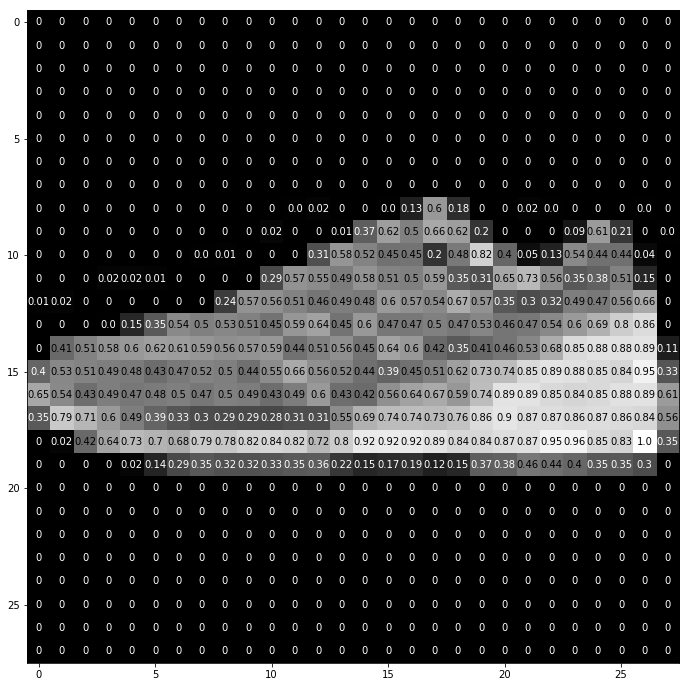

In [6]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

In [20]:
first_layer_neurans = 512
second_layer_neurans = 128
third_layer_neurans = 64 
dropOutProp = 0.15


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(28 * 28, first_layer_neurans)
        self.fc2 = nn.Linear(first_layer_neurans,second_layer_neurans)
        self.fc3 = nn.Linear(second_layer_neurans,third_layer_neurans)
        self.fc4 = nn.Linear(third_layer_neurans,10)
        self.dropout = nn.Dropout(p=dropOutProp)

    def forward(self, image):
        # flatten image input
        image = image.view(-1, 28 * 28)
        image = self.dropout(F.relu(self.fc1(image)))
        image = self.dropout(F.relu(self.fc2(image)))
        image = self.dropout(F.relu(self.fc3(image)))
        image = F.log_softmax(self.fc4(image),dim=1)
        return image

# initialize the NN
model = Net()
model.to(device)
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.15)
)


In [21]:
# specify loss function
criterion = nn.NLLLoss()
# specify optimizer
optimizer = optim.Adam(model.parameters(),lr=0.01)

In [22]:
n_epochs = 150

min_validation_loss = np.inf #save min loss value to use while training 

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        data , target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
    
    #Validation Step 
    model.eval() # to stop dropout if exists
    validation_loss = 0
    with torch.no_grad():        
        for data, target in valid_loader:
            #same as training BUT without optimizer step 
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output,target)
            validation_loss += loss.item()*data.size(0)
    
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/train_sampler.indices.__len__()
    Validation_loss = validation_loss/valid_sampler.indices.__len__()
    if validation_loss < min_validation_loss :
        print("Saving model")
        min_validation_loss = validation_loss
        torch.save(model.state_dict(), 'model.pt')
    print('Epoch: {} \nTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1, train_loss,Validation_loss))

Saving model
Epoch: 1 
Training Loss: 0.694933 	Validation Loss: 0.468361
Saving model
Epoch: 2 
Training Loss: 0.422652 	Validation Loss: 0.406881
Saving model
Epoch: 3 
Training Loss: 0.387054 	Validation Loss: 0.388399
Epoch: 4 
Training Loss: 0.366536 	Validation Loss: 0.427533
Saving model
Epoch: 5 
Training Loss: 0.347362 	Validation Loss: 0.387192
Saving model
Epoch: 6 
Training Loss: 0.339424 	Validation Loss: 0.377723
Epoch: 7 
Training Loss: 0.326953 	Validation Loss: 0.422674
Saving model
Epoch: 8 
Training Loss: 0.321224 	Validation Loss: 0.360897
Epoch: 9 
Training Loss: 0.310184 	Validation Loss: 0.388378
Epoch: 10 
Training Loss: 0.314125 	Validation Loss: 0.368739
Saving model
Epoch: 11 
Training Loss: 0.302281 	Validation Loss: 0.360838
Epoch: 12 
Training Loss: 0.305444 	Validation Loss: 0.549916
Epoch: 13 
Training Loss: 0.297106 	Validation Loss: 0.375436
Saving model
Epoch: 14 
Training Loss: 0.287075 	Validation Loss: 0.352004
Epoch: 15 
Training Loss: 0.276666 	V

Epoch: 132 
Training Loss: 0.216464 	Validation Loss: 0.602158
Epoch: 133 
Training Loss: 0.208403 	Validation Loss: 0.721212
Epoch: 134 
Training Loss: 0.184581 	Validation Loss: 0.676649
Epoch: 135 
Training Loss: 0.194045 	Validation Loss: 0.743274
Epoch: 136 
Training Loss: 0.194413 	Validation Loss: 0.622265
Epoch: 137 
Training Loss: 0.210498 	Validation Loss: 0.676072
Epoch: 138 
Training Loss: 0.190444 	Validation Loss: 0.614200
Epoch: 139 
Training Loss: 0.178882 	Validation Loss: 0.630602
Epoch: 140 
Training Loss: 0.167028 	Validation Loss: 0.683309
Epoch: 141 
Training Loss: 0.222543 	Validation Loss: 0.646767
Epoch: 142 
Training Loss: 0.191380 	Validation Loss: 0.610162
Epoch: 143 
Training Loss: 0.198073 	Validation Loss: 0.636876
Epoch: 144 
Training Loss: 0.179746 	Validation Loss: 0.649188
Epoch: 145 
Training Loss: 0.196239 	Validation Loss: 0.764210
Epoch: 146 
Training Loss: 0.185999 	Validation Loss: 0.785487
Epoch: 147 
Training Loss: 0.181014 	Validation Loss: 0

In [24]:
torch.save(model.state_dict(), 'model150.pt')
model.load_state_dict(torch.load('model.pt'))

In [25]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    data , target = data.to(device) , target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(target.shape[0]):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.379010

Test Accuracy of     0: 85% (856/1000)
Test Accuracy of     1: 96% (962/1000)
Test Accuracy of     2: 82% (829/1000)
Test Accuracy of     3: 89% (894/1000)
Test Accuracy of     4: 80% (804/1000)
Test Accuracy of     5: 94% (949/1000)
Test Accuracy of     6: 58% (581/1000)
Test Accuracy of     7: 95% (958/1000)
Test Accuracy of     8: 97% (978/1000)
Test Accuracy of     9: 94% (943/1000)

Test Accuracy (Overall): 87% (8754/10000)


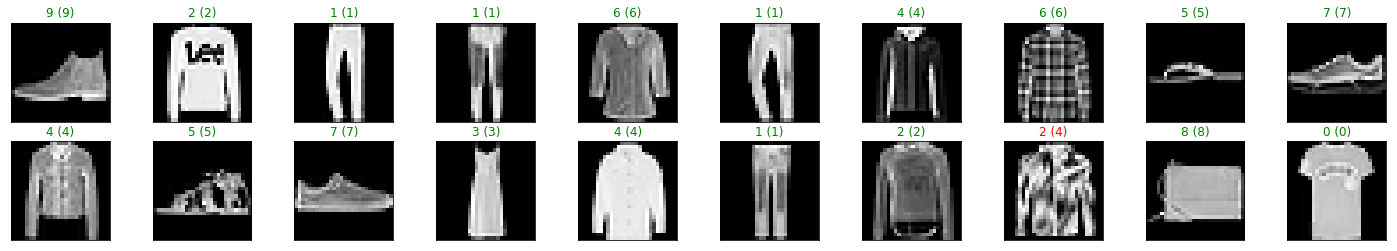

In [26]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images , labels = images.to(device) , labels.to(device)
# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.cpu().numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))